# Codelab 03: Feature Extraction and Object Classification

Loaded array has shape: (3744, 5616, 3)
Loaded values are of type: uint8


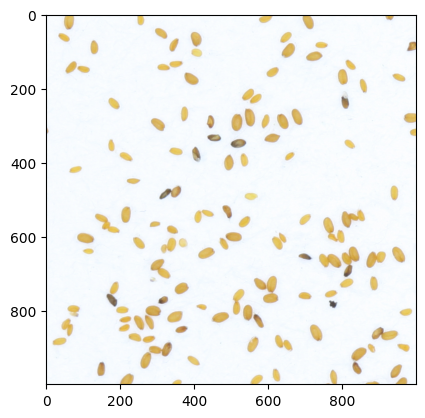

In [6]:
filepath = r'../example_images/seed_img.JPG'

from skimage.io import imread
import matplotlib.pyplot as plt

img = imread(filepath)

print("Loaded array has shape:", img.shape)
print("Loaded values are of type:", img.dtype)

plt.imshow(img[y_start: y_end, x_start: x_end])

In [4]:
# Split channel
img_ch0 = img[:,:,0]
img_ch1 = img[:,:,1]
img_ch2 = img[:,:,2]

Text(0.5, 1.0, 'ch2')

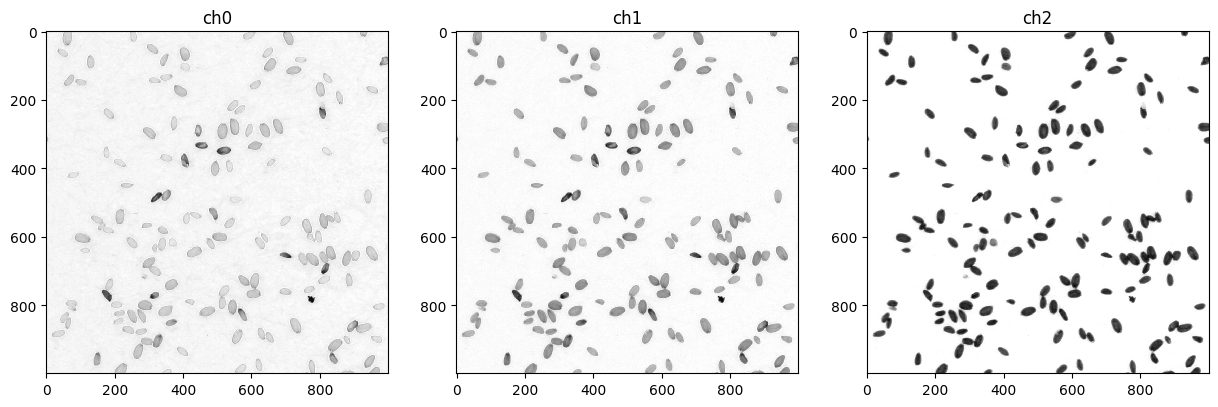

In [5]:
import matplotlib.pyplot as plt

# Define a range to visulize
x_start = 1000
x_end = 2000
y_start = 1000
y_end = 2000

plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(img_ch0[y_start: y_end, x_start: x_end], cmap = 'gray', interpolation='none')
plt.title('ch0')
plt.subplot(132)
plt.imshow(img_ch1[y_start: y_end, x_start: x_end], cmap = 'gray', interpolation='none')
plt.title('ch1')
plt.subplot(133)
plt.imshow(img_ch2[y_start: y_end, x_start: x_end], cmap = 'gray', interpolation='none')
plt.title('ch2')

Text(0.5, 1.0, 'Segmented image by Otsu thresholding')

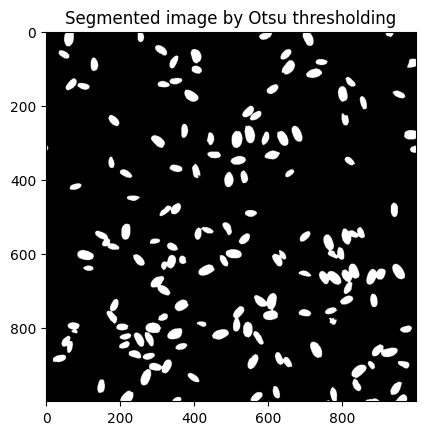

In [7]:
# Calculate Otsu's threshold by threshold_otsu from `skimage.filters.thresholding`
from skimage.filters.thresholding import threshold_otsu
# Calculate threshold
thresh = threshold_otsu(img_ch2)
# Perform Global thresholding with the calculated threshold
seeds_seg = img_ch2 < thresh
# Show the segmented image
plt.imshow(seeds_seg[y_start: y_end, x_start: x_end], cmap = 'gray')
plt.title('Segmented image by Otsu thresholding')

In [8]:
# (i) Run a distance transform on the seeds seg
# The image processing module scipy.ndimage as ndi
import scipy.ndimage as ndi

# Use the function 'ndi.distance_transform_edt' for distance transform
dist_trans = ndi.distance_transform_edt(seeds_seg)

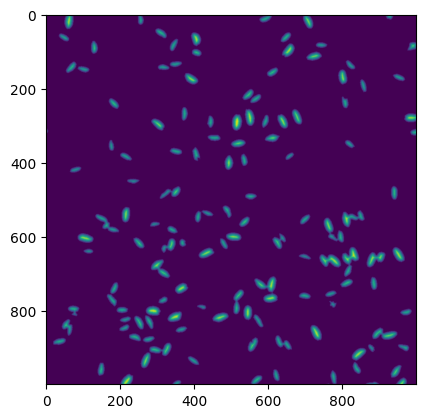

In [9]:
# (ii) Visualize the output and understand what you are seeing.
plt.imshow(dist_trans[y_start: y_end, x_start: x_end])

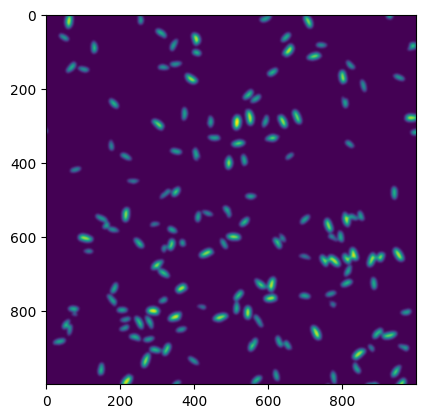

In [10]:
# (iii) Smoothen the distance transform
# Use `ndi.gaussian_filter`
dist_trans_smooth = ndi.gaussian_filter(dist_trans, sigma=3)

# Show result
plt.imshow(dist_trans_smooth[y_start: y_end, x_start: x_end])

In [11]:
# (iv) Get the local maxima (the 'peaks') from the distance transform

# Use the function 'peak_local_max' from the module 'skimage.feature'. This function will return the
# indices/ coordinates of the pixels where the local maxima are. 

from skimage.feature import peak_local_max

seeds = peak_local_max(dist_trans_smooth, min_distance=8)

In [13]:
# (v) However, we instead need a boolean mask of the same shape as the original image, where all 
# the local maximum pixels are labeled as `1` and everything else as `0`.

# Let's do it step by step. First try have a look at what is in seeds. Can you get these values?
# Number of seeds
import numpy as np
print(f'There are {np.shape(seeds)[0]} seeds')
# The X coordinate of the first seed
print(seeds[0][0])
# The Y coordinate of the 13th seed
print(seeds[13][1])

There are 2235 seeds
3175
778


In [14]:
# Now, we will start by creating a boolean matrix/ image same size as the original image, but with
# all pixel values as 0/ false
seeds_mask = np.zeros_like(dist_trans_smooth, dtype = bool)

# For loop through all entries in seeds
for seed_id in range(np.shape(seeds)[0]):
    seeds_mask[seeds[seed_id][0],seeds[seed_id][1]] = 1

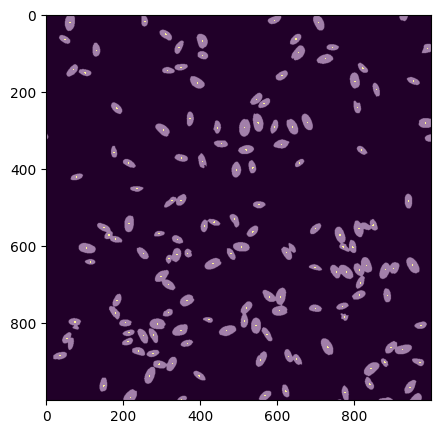

In [15]:
# (vi) Visualize the output 
# Expand seeds mask and show results
from skimage.morphology import disk

seeds_dil = ndi.binary_dilation(seeds_mask, disk(2))

plt.figure(figsize=(5,5))
plt.imshow(seeds_seg[y_start: y_end, x_start: x_end], cmap = 'gray')
plt.imshow(seeds_dil[y_start: y_end, x_start: x_end], interpolation='none', alpha = 0.5)

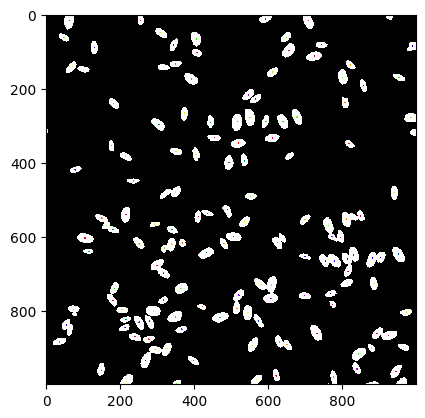

In [16]:
# (vii) Label the seeds
seeds_labeled = ndi.label(seeds_dil)[0]

# Visualize
seeds_labeled_mask = np.ma.array(seeds_labeled, mask=seeds_labeled==0)
plt.imshow(seeds_seg[y_start: y_end, x_start: x_end], interpolation='none', cmap='gray')
plt.imshow(seeds_labeled_mask[y_start: y_end, x_start: x_end], interpolation='none', cmap='prism')

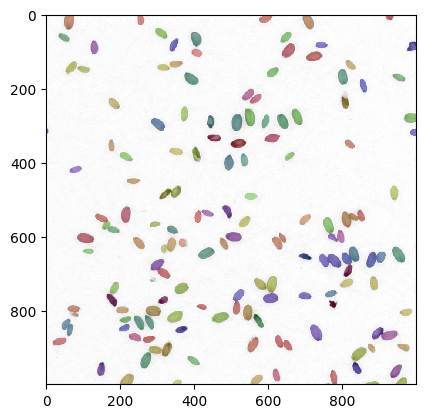

In [17]:
# (i) Perform watershed
from skimage.segmentation import watershed

seed_rois = watershed(-dist_trans, markers=seeds_labeled, mask = seeds_seg)

seeds_seed_rois_mask = np.ma.array(seed_rois, mask=seed_rois==0)
plt.imshow(img_ch1[y_start: y_end, x_start: x_end], interpolation='none', cmap='gray')
plt.imshow(seeds_seed_rois_mask[y_start: y_end, x_start: x_end], interpolation='none', cmap='prism', alpha = 0.3)

In [19]:
# Import imsave from skimage.io
from skimage.io import imsave

# Save image
imsave(r"../example_images/seed_labels.tif", seed_rois.astype(np.uint16))

C:\Users\OWNER\AppData\Local\Temp\ipykernel_23144\3449129382.py:5: UserWarning: ../example_images/seed_labels.tif is a low contrast image
  imsave(r"../example_images/seed_labels.tif", seed_rois.astype(np.uint16))
